In [1]:
%config Completer.use_jedi = False

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yaml 
import glob
import math

from scipy.stats import spearmanr

In [2]:
with open('/data/hookbill/hadfield/syntheticVS/data/EGNN_attribution_dfs/attribution_df_pdbbind_small_hydrophobic.yaml', 'r') as f:
    egnn_zinc_dfs = yaml.load(f, Loader=yaml.Loader)

In [3]:
def load_yaml(fname):
    
    with open(fname, 'r') as f:
        y = yaml.load(f, Loader=yaml.Loader)
        
    for k in y.keys():
        y[k] = pd.DataFrame(y[k])
        y[k].columns = ['x', 'y', 'z', 'atomic_num', 'atom_type', 'lig', 'attrbution', 'binding']
        
    return y
    

In [4]:
egnn_zinc_dfs = load_yaml('/data/hookbill/hadfield/syntheticVS/data/EGNN_attribution_dfs/attribution_df_zinc_Masking.yaml')
egnn_pdbbind_dfs = load_yaml('/data/hookbill/hadfield/syntheticVS/data/EGNN_attribution_dfs/attribution_df_pdbbind_small_hydrophobic.yaml')

In [54]:
egnn_pdbbind_dfs_200k = load_yaml('/data/hookbill/hadfield/syntheticVS/data/EGNN_attribution_dfs/attribution_df_pdbbind_small_hydrophobic_200k.yaml')

In [5]:
rf_pdbbind_dfs = {}
rf_pdbbind_correlations = {}

for pc in ['25', '3', '35', '4', '45', '5', '55', '6']:
    rf_pdbbind_dfs[pc] = [pd.read_csv(x, sep = ' ') for x in glob.glob(f'/data/hookbill/hadfield/syntheticVS/data/pdbbind_small_hydrophobic_filtered_test_set/attributions_dir_{pc}/df*.csv')]

    correlations_vec = [spearmanr(x['attribution'], x['binding']).correlation for x in rf_pdbbind_dfs[pc]]
    print(sum([math.isnan(x) for x in correlations_vec]))
    
    rf_pdbbind_correlations[pc] = np.nanmean(correlations_vec)
    print(pc, rf_pdbbind_correlations[pc])
    

/data/hookbill/hadfield/anaconda3/envs/DeLinker-env/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/data/hookbill/hadfield/anaconda3/envs/DeLinker-env/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/data/hookbill/hadfield/anaconda3/envs/DeLinker-env/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/data/hookbill/hadfield/anaconda3/envs/DeLinker-env/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/data/hookbill/hadfield/anaconda3/envs/DeLinker-env/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond

76
25 0.0062358489577614105
15
3 0.027295577622364044
37
35 0.03861486495709621
0
4 0.04610715082794234
0
45 0.08239568801277086
0
5 0.08655416609106577
0
55 0.0625726513369903
0
6 0.09305331146503187


In [6]:
#rf_pdbbind_dfs_fnames = glob.glob('/data/hookbill/hadfield/syntheticVS/data/pdbbind_filtered_test_set_hydrophobic/attribution_dfs/df*.csv')
#rf_pdbbind_dfs = [pd.read_csv(x, sep = ' ') for x in rf_pdbbind_dfs_fnames]

rf_zinc_dfs_fnames = glob.glob('/data/hookbill/hadfield/syntheticVS/data/zinc_hydrophobic_forced_50ops_ac0025_st4_split/attribution_dfs/df*.csv')
rf_zinc_dfs = [pd.read_csv(x, sep = ' ') for x in rf_zinc_dfs_fnames]
print(len(rf_zinc_dfs_fnames))

2005


In [9]:
rf_pdbbind_dfs['25'][0]

,atom_idx,x,y,z,attribution,binding
0,0,-1.4403,-2.5451,-1.3388,0.530199,2.628034
1,1,-1.1892,-1.5401,-0.4217,0.530199,0.000000
2,2,0.1173,-1.1082,-0.5565,0.530199,0.248848
3,3,0.4870,-0.1775,0.3962,0.530199,0.000000
4,4,1.9122,0.2332,0.1741,0.530199,0.000000
5,5,2.7575,-0.8180,-0.1302,0.530199,0.266469
6,6,4.3762,-0.2904,0.1058,0.530199,0.000000
7,7,4.5882,1.0573,-0.5997,0.530199,0.487414
8,8,4.6540,-0.1345,1.6085,0.530199,0.252135
9,9,5.3412,-1.3305,-0.4831,0.530199,0.090332


In [9]:
def avg_rank_above_threshold(threshold, df, sort_by_binding = False, random_ranking = False):
    
    if sort_by_binding:
        df = df.sort_values('binding', ascending = False).reset_index(drop=True)
    
    if random_ranking:
        df['random'] = np.random.uniform(size=df.shape[0])
        df = df.sort_values('random', ascending = False).reset_index(drop=True)
    
    above_df = df.loc[df['binding'] > threshold]
    
    indices_above_threshold = list(above_df.index)
    indices_above_threshold = [x + 1 for x in indices_above_threshold]
    
    if len(indices_above_threshold) == 0:
        return -1
    else:
        return np.mean(indices_above_threshold)

def get_high_rank_sum_stat(df_list, thresholds, sort_by_binding = False, random_ranking = False):
    
    all_thresholds = []
    
    for t in thresholds:
        
        df_ranks = []
        
        for df in df_list:
            single_example = avg_rank_above_threshold(t, df, sort_by_binding, random_ranking)
            if single_example != -1:
                df_ranks.append(single_example)
            
        all_thresholds.append(np.mean(df_ranks))
    
    return all_thresholds

In [8]:
test = egnn_pdbbind_dfs[20]
list(test.loc[test['binding'] > 1].index)

[0, 1, 2]

In [10]:
avg_rank_stat_pdbbind_egnn = get_high_rank_sum_stat(list(egnn_pdbbind_dfs.values()), np.arange(0.5, 3, 0.05))
#avg_rank_stat_pdbbind_rf = get_high_rank_sum_stat(rf_pdbbind_dfs, np.arange(0.5, 3, 0.05))

avg_rank_stat_pdbbind_rf = {}


for pc in ['25', '3', '35', '4', '45', '5', '55', '6']:

    avg_rank_stat_pdbbind_rf[pc] = get_high_rank_sum_stat(rf_pdbbind_dfs[pc], np.arange(0.5, 3, 0.05))
    


In [14]:
avg_rank_stat_pdbbind_egnn_best = get_high_rank_sum_stat(list(egnn_pdbbind_dfs.values()), np.arange(0.5, 3, 0.05), sort_by_binding=True)
avg_rank_stat_pdbbind_egnn_baseline = get_high_rank_sum_stat(list(egnn_pdbbind_dfs.values()), np.arange(0.5, 3, 0.05), random_ranking=True)



In [11]:
#avg_rank_stat_zinc_egnn = get_high_rank_sum_stat(list(egnn_zinc_dfs.values()), np.arange(0.5, 3, 0.05))
avg_rank_stat_zinc_rf = get_high_rank_sum_stat(rf_zinc_dfs, np.arange(0.5, 3, 0.05))


In [12]:
avg_rank_stat_zinc_rf

[9.454474843922144,
 9.292775359110587,
 9.164666245916246,
 8.963794238989959,
 8.816406015037593,
 8.653240529438612,
 8.514329260483107,
 8.380350033607364,
 8.210882491002973,
 8.039645747923894,
 7.868901303538174,
 7.708958450836623,
 7.533342830009497,
 7.370025019245573,
 7.205110981308411,
 6.976690321308889,
 6.7865704550010015,
 6.640193089430894,
 6.393184634448574,
 6.115787269681741,
 5.924650127226463,
 5.788805970149253,
 5.754675066312997,
 5.600011230907458,
 5.543493150684932,
 5.486963118580766,
 5.416222382324688,
 5.26012036354704,
 5.175465760322257,
 5.141952678107124,
 5.100692182410423,
 5.066102173299464,
 5.011931984755203,
 4.939360393603936,
 4.977905491698595,
 4.977938247011952,
 4.914427083333334,
 4.955914567360351,
 4.975872093023256,
 4.943077873918417,
 4.941291887125221,
 4.8307511737089195,
 4.857791225416037,
 4.925837320574162,
 4.822727272727272,
 4.836071184120465,
 4.814564564564564,
 4.772855987055017,
 4.718941382327209,
 4.708217913204062]

0 25 4
1 3 5
2 35 6
3 4 7
4 45 8
5 5 9
6 55 10
7 6 11


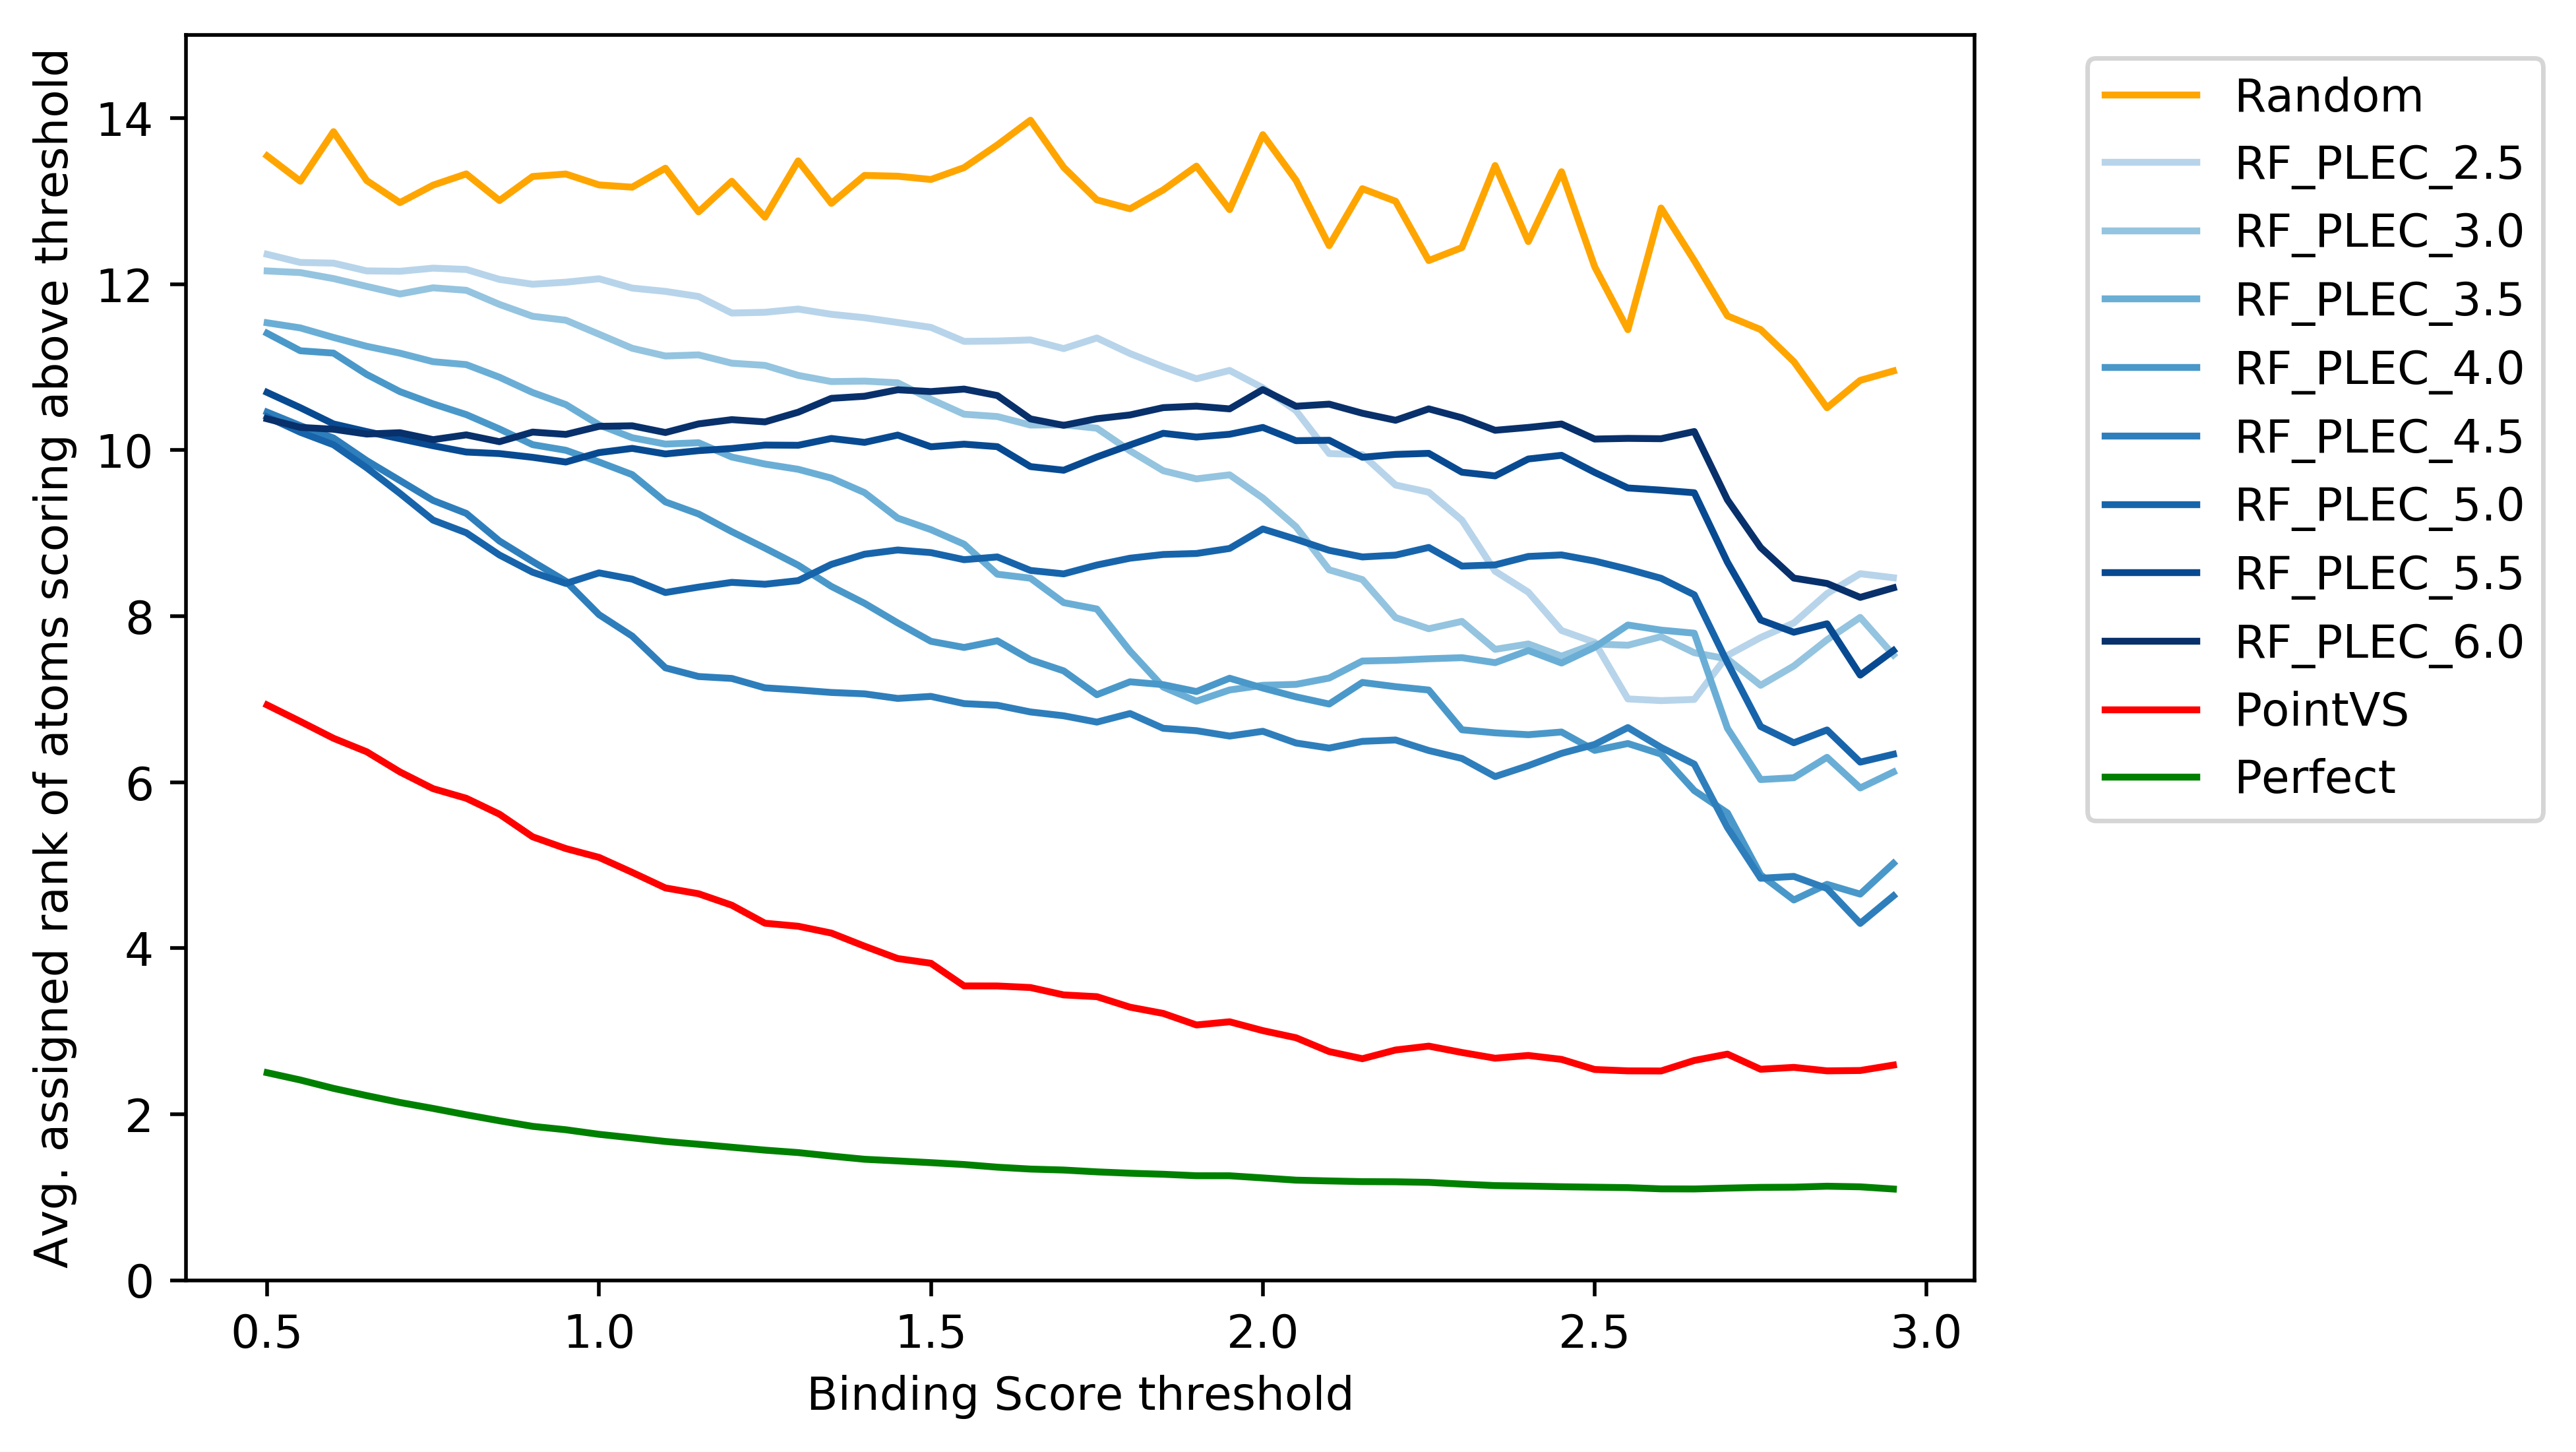

In [21]:
import matplotlib as mpl
c = np.arange(1, len(avg_rank_stat_pdbbind_rf.keys()) + 4)

norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Blues)
cmap.set_array([])


plt.figure(figsize = (7,5), dpi=500)

#plt.plot(np.arange(0.5, 3, 0.05), avg_rank_stat_pdbbind_egnn_200k, label = 'egnn_200k')

#plt.plot(np.arange(0.5, 3, 0.05), avg_rank_stat_pdbbind_rf, label = 'rf')


plt.plot(np.arange(0.5, 3, 0.05), avg_rank_stat_pdbbind_egnn_baseline, label = 'Random', color = 'orange')


for i, pc in enumerate(avg_rank_stat_pdbbind_rf.keys()):
    print(i, pc, i + 4)
    
    if len(pc) == 2:
        pc_str = f'{pc[0]}.{pc[1]}'
    elif len(pc) == 1:
        pc_str = f'{pc[0]}.0'
    
    plt.plot(np.arange(0.5, 3, 0.05), avg_rank_stat_pdbbind_rf[pc], label = f'RF_PLEC_{pc_str}', color=cmap.to_rgba(i + 4))

plt.plot(np.arange(0.5, 3, 0.05), avg_rank_stat_pdbbind_egnn, label = 'PointVS', color = 'red')
plt.plot(np.arange(0.5, 3, 0.05), avg_rank_stat_pdbbind_egnn_best, label = 'Perfect', color = 'green')    
    
plt.ylim((0,15))
plt.xlabel('Binding Score threshold')
plt.ylabel('Avg. assigned rank of atoms scoring above threshold')
#plt.legend()
plt.legend(bbox_to_anchor=(1.05, 1))

#plt.savefig('/data/hookbill/hadfield/syntheticVS/figures_for_paper/hydrophobic_attribution_2.png', bbox_inches='tight')
plt.show()


In [19]:
str(float('3'))

'3.0'

In [18]:
avg_rank_stat_pdbbind_rf.keys()

dict_keys(['25', '3', '35', '4', '45', '5', '55', '6'])

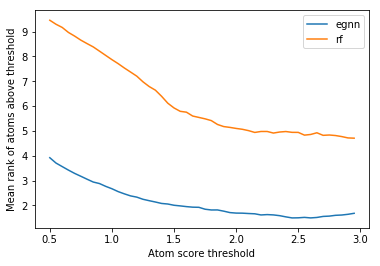

In [85]:
plt.plot(np.arange(0.5, 3, 0.05), avg_rank_stat_zinc_egnn, label = 'egnn')
plt.plot(np.arange(0.5, 3, 0.05), avg_rank_stat_zinc_rf, label = 'rf')
plt.xlabel('Atom score threshold')
plt.ylabel('Mean rank of atoms above threshold')
plt.legend()
plt.show()

In [22]:
rf_pdbbind_dfs['25'][0].sort_values('binding', ascending = False).reset_index(drop=True)

,atom_idx,x,y,z,attribution,binding
0,0,-1.4403,-2.5451,-1.3388,0.530199,2.628034
1,11,0.0160,1.9588,1.2998,0.530199,1.668288
2,13,-2.7151,1.6563,0.5504,0.530199,1.345478
3,15,-3.4237,-0.7203,-0.7044,0.530199,1.338088
4,7,4.5882,1.0573,-0.5997,0.530199,0.487414
5,5,2.7575,-0.8180,-0.1302,0.530199,0.266469
6,8,4.6540,-0.1345,1.6085,0.530199,0.252135
7,2,0.1173,-1.1082,-0.5565,0.530199,0.248848
8,9,5.3412,-1.3305,-0.4831,0.530199,0.090332
9,1,-1.1892,-1.5401,-0.4217,0.530199,0.000000


In [23]:
#Load in biased yaml files

In [24]:
biased_dfs = {}
import glob
target_directories = glob.glob('/data/hookbill/hadfield/syntheticVS/data/EGNN_attribution_dfs/biased_attribution_performance/*')
targets = [x.split('/')[-1] for x in target_directories]

for target in targets:
    biased_dfs[target] = load_yaml(f'/data/hookbill/hadfield/syntheticVS/data/EGNN_attribution_dfs/biased_attribution_performance/{target}/attribution_df_CAM.yaml')



In [25]:
biased_dfs['DUDE_MK14']

{0:          x       y       z  atomic_num  atom_type  lig  attrbution   binding
 0  -3.1693  2.6161  0.4253        15.0        7.0  0.0   28.435034  0.000000
 1   2.5692  0.1559  0.1458        15.0        7.0  0.0   22.113731  0.000000
 2   5.1753  1.1412 -0.1887        15.0        7.0  0.0   21.544851  0.000000
 3   0.3789 -0.9162  1.0215         6.0        3.0  0.0   20.986572  0.000000
 4   0.2459 -1.3974 -0.3777         6.0        3.0  0.0    9.189808  0.000000
 5  -3.0073  0.0911  0.5008         6.0        3.0  0.0    8.542335  0.000000
 6  -1.8033 -0.8086  0.5716         6.0        3.0  0.0   -1.552266  0.000000
 7  -1.1119 -0.8282 -0.7857         6.0        3.0  0.0   -4.900540  0.000000
 8   0.0780 -2.7918 -0.4245         8.0        5.0  0.0  -40.223026  0.938543
 9   3.2336 -1.0568 -0.4459         8.0        5.0  0.0  -59.603455  1.181479
 10  5.5028 -0.2638 -0.7196         8.0        5.0  0.0  -78.164459  0.723206
 11 -1.7521 -1.6753 -1.6738         8.0        5.0  0.0  -78.

In [26]:
#avg_rank_stat_pdbbind_egnn = get_high_rank_sum_stat(list(egnn_pdbbind_dfs.values()), np.arange(0.5, 3, 0.05))
#avg_rank_stat_pdbbind_rf = get_high_rank_sum_stat(rf_pdbbind_dfs, np.arange(0.5, 3, 0.05))

avg_rank_stat_pdbbind_egnn_biased = {}


for target in targets:
    print(target)
    avg_rank_stat_pdbbind_egnn_biased[target] = get_high_rank_sum_stat(list(biased_dfs[target].values()), np.arange(0.5, 3, 0.05))





DUDE_MK14
LIT_PKM2
LIT_FEN1
LIT_MAPK1
LIT_VDR
DUDE_VGFR2
LIT_ALDH1
DUDE_FA10
DUDE_AA2AR


0 DUDE_AA2AR 4
1 DUDE_FA10 5
2 DUDE_MK14 6
3 DUDE_VGFR2 7
4 LIT_ALDH1 8
5 LIT_FEN1 9
6 LIT_MAPK1 10
7 LIT_PKM2 11
8 LIT_VDR 12


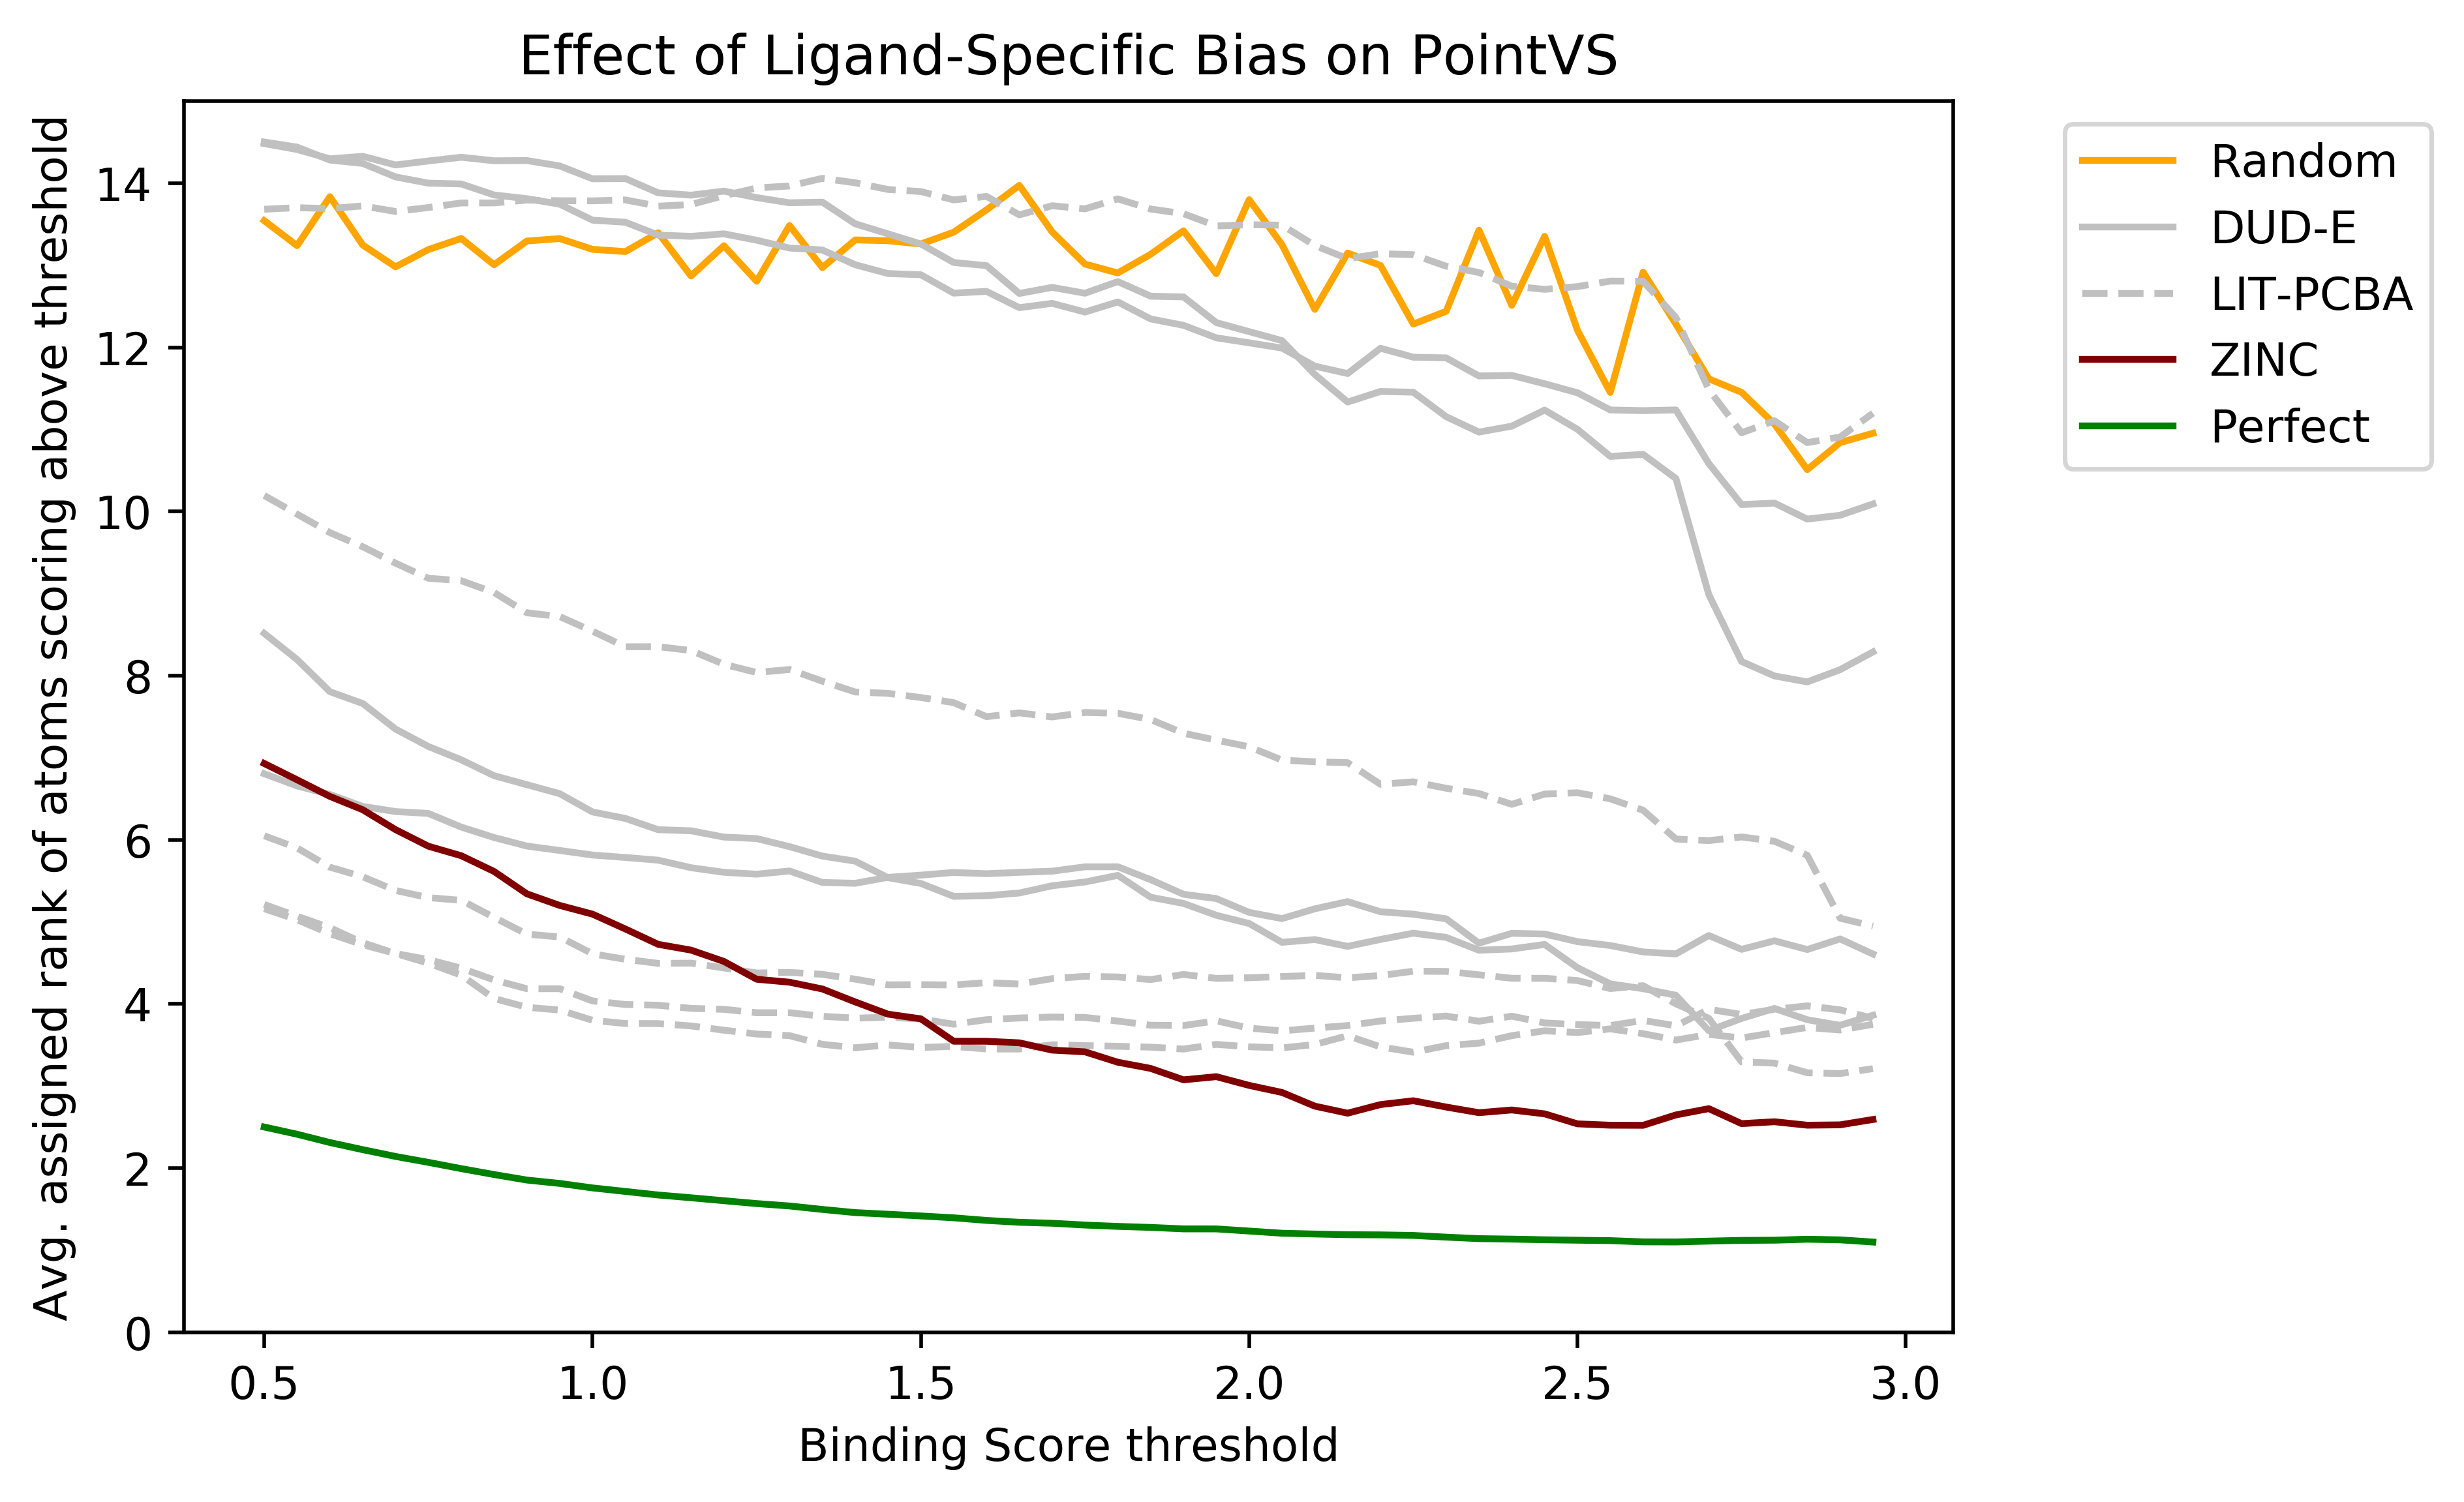

In [42]:
import matplotlib as mpl
c = np.arange(1, len(avg_rank_stat_pdbbind_rf.keys()) + 4)

norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Blues)
cmap.set_array([])


plt.figure(figsize = (7,5), dpi=500)

#plt.plot(np.arange(0.5, 3, 0.05), avg_rank_stat_pdbbind_egnn_200k, label = 'egnn_200k')

#plt.plot(np.arange(0.5, 3, 0.05), avg_rank_stat_pdbbind_rf, label = 'rf')


plt.plot(np.arange(0.5, 3, 0.05), avg_rank_stat_pdbbind_egnn_baseline, label = 'Random', color = 'orange')


#for i, pc in enumerate(avg_rank_stat_pdbbind_rf.keys()):
#    print(i, pc, i + 4)
#    plt.plot(np.arange(0.5, 3, 0.05), avg_rank_stat_pdbbind_rf[pc], label = f'rf_plec_{pc}', color=cmap.to_rgba(i + 4))

first_dude = True
first_lit = True

for i, target in enumerate(sorted(avg_rank_stat_pdbbind_egnn_biased.keys())):
    print(i, target, i + 4)
    #plt.plot(np.arange(0.5, 3, 0.05), avg_rank_stat_pdbbind_egnn_biased[target], label = f'{target}', color=cmap.to_rgba(i + 4))
    if 'DUDE' in target:
        if first_dude:
            plt.plot(np.arange(0.5, 3, 0.05), avg_rank_stat_pdbbind_egnn_biased[target], label = f'DUD-E', color="silver")
            first_dude = False
        else:
            plt.plot(np.arange(0.5, 3, 0.05), avg_rank_stat_pdbbind_egnn_biased[target], color="silver")

        
    if 'LIT' in target:
        if first_lit:
            plt.plot(np.arange(0.5, 3, 0.05), avg_rank_stat_pdbbind_egnn_biased[target], label = f'LIT-PCBA', color="silver", linestyle = 'dashed')
            first_lit = False
        else:
            plt.plot(np.arange(0.5, 3, 0.05), avg_rank_stat_pdbbind_egnn_biased[target], color="silver", linestyle = 'dashed')

    
plt.plot(np.arange(0.5, 3, 0.05), avg_rank_stat_pdbbind_egnn, label = 'ZINC', color = 'maroon')
plt.plot(np.arange(0.5, 3, 0.05), avg_rank_stat_pdbbind_egnn_best, label = 'Perfect', color = 'green')    
    
plt.ylim((0,15))
plt.xlabel('Binding Score threshold')
plt.ylabel('Avg. assigned rank of atoms scoring above threshold')
#plt.legend()
plt.legend(bbox_to_anchor=(1.05, 1))
plt.title('Effect of Ligand-Specific Bias on PointVS')

#plt.savefig('/data/hookbill/hadfield/syntheticVS/figures_for_paper/hydrophobic_attribution_2.png', bbox_inches='tight')
plt.show()

# Hydrophobic bias for RF model

In [38]:
print(targets)

['DUDE_MK14', 'LIT_PKM2', 'LIT_FEN1', 'LIT_MAPK1', 'LIT_VDR', 'DUDE_VGFR2', 'LIT_ALDH1', 'DUDE_FA10', 'DUDE_AA2AR']


In [39]:
rf_pdbbind_biased_dfs = {}
rf_pdbbind_biased_correlations = {}


    
for target in sorted(targets):
    
    rf_pdbbind_biased_dfs[target] = [pd.read_csv(x, sep = ' ') for x in glob.glob(f'/data/hookbill/hadfield/syntheticVS/data/pdbbind_small_hydrophobic_filtered_test_set/attributions_dir_{target}_4/df*.csv')]

    correlations_vec = [spearmanr(x['attribution'], x['binding']).correlation for x in rf_pdbbind_biased_dfs[target]]
    print(sum([math.isnan(x) for x in correlations_vec]))
    
    rf_pdbbind_biased_correlations[target] = np.nanmean(correlations_vec)
    print(pc, rf_pdbbind_biased_correlations[target])
    
    


0
6 0.04605835252167391
0
6 0.04035559690033235
0
6 0.01672281637889041
0
6 0.06664706542944578
0
6 0.047018001218216775
0
6 0.10911162923269126
0
6 0.061744324215864184
0
6 0.07492172313645011
0
6 0.08604385157199798


In [40]:
avg_rank_stat_pdbbind_biased_rf = {}


#for pc in ['25', '3', '35', '4', '45', '5', '55', '6']:

for target in targets:
    avg_rank_stat_pdbbind_biased_rf[target] = get_high_rank_sum_stat(rf_pdbbind_biased_dfs[target], np.arange(0.5, 3, 0.05))
    

0 DUDE_AA2AR 4
1 DUDE_FA10 5
2 DUDE_MK14 6
3 DUDE_VGFR2 7
4 LIT_ALDH1 8
5 LIT_FEN1 9
6 LIT_MAPK1 10
7 LIT_PKM2 11
8 LIT_VDR 12
0 DUDE_AA2AR 4
1 DUDE_FA10 5
2 DUDE_MK14 6
3 DUDE_VGFR2 7
4 LIT_ALDH1 8
5 LIT_FEN1 9
6 LIT_MAPK1 10
7 LIT_PKM2 11
8 LIT_VDR 12


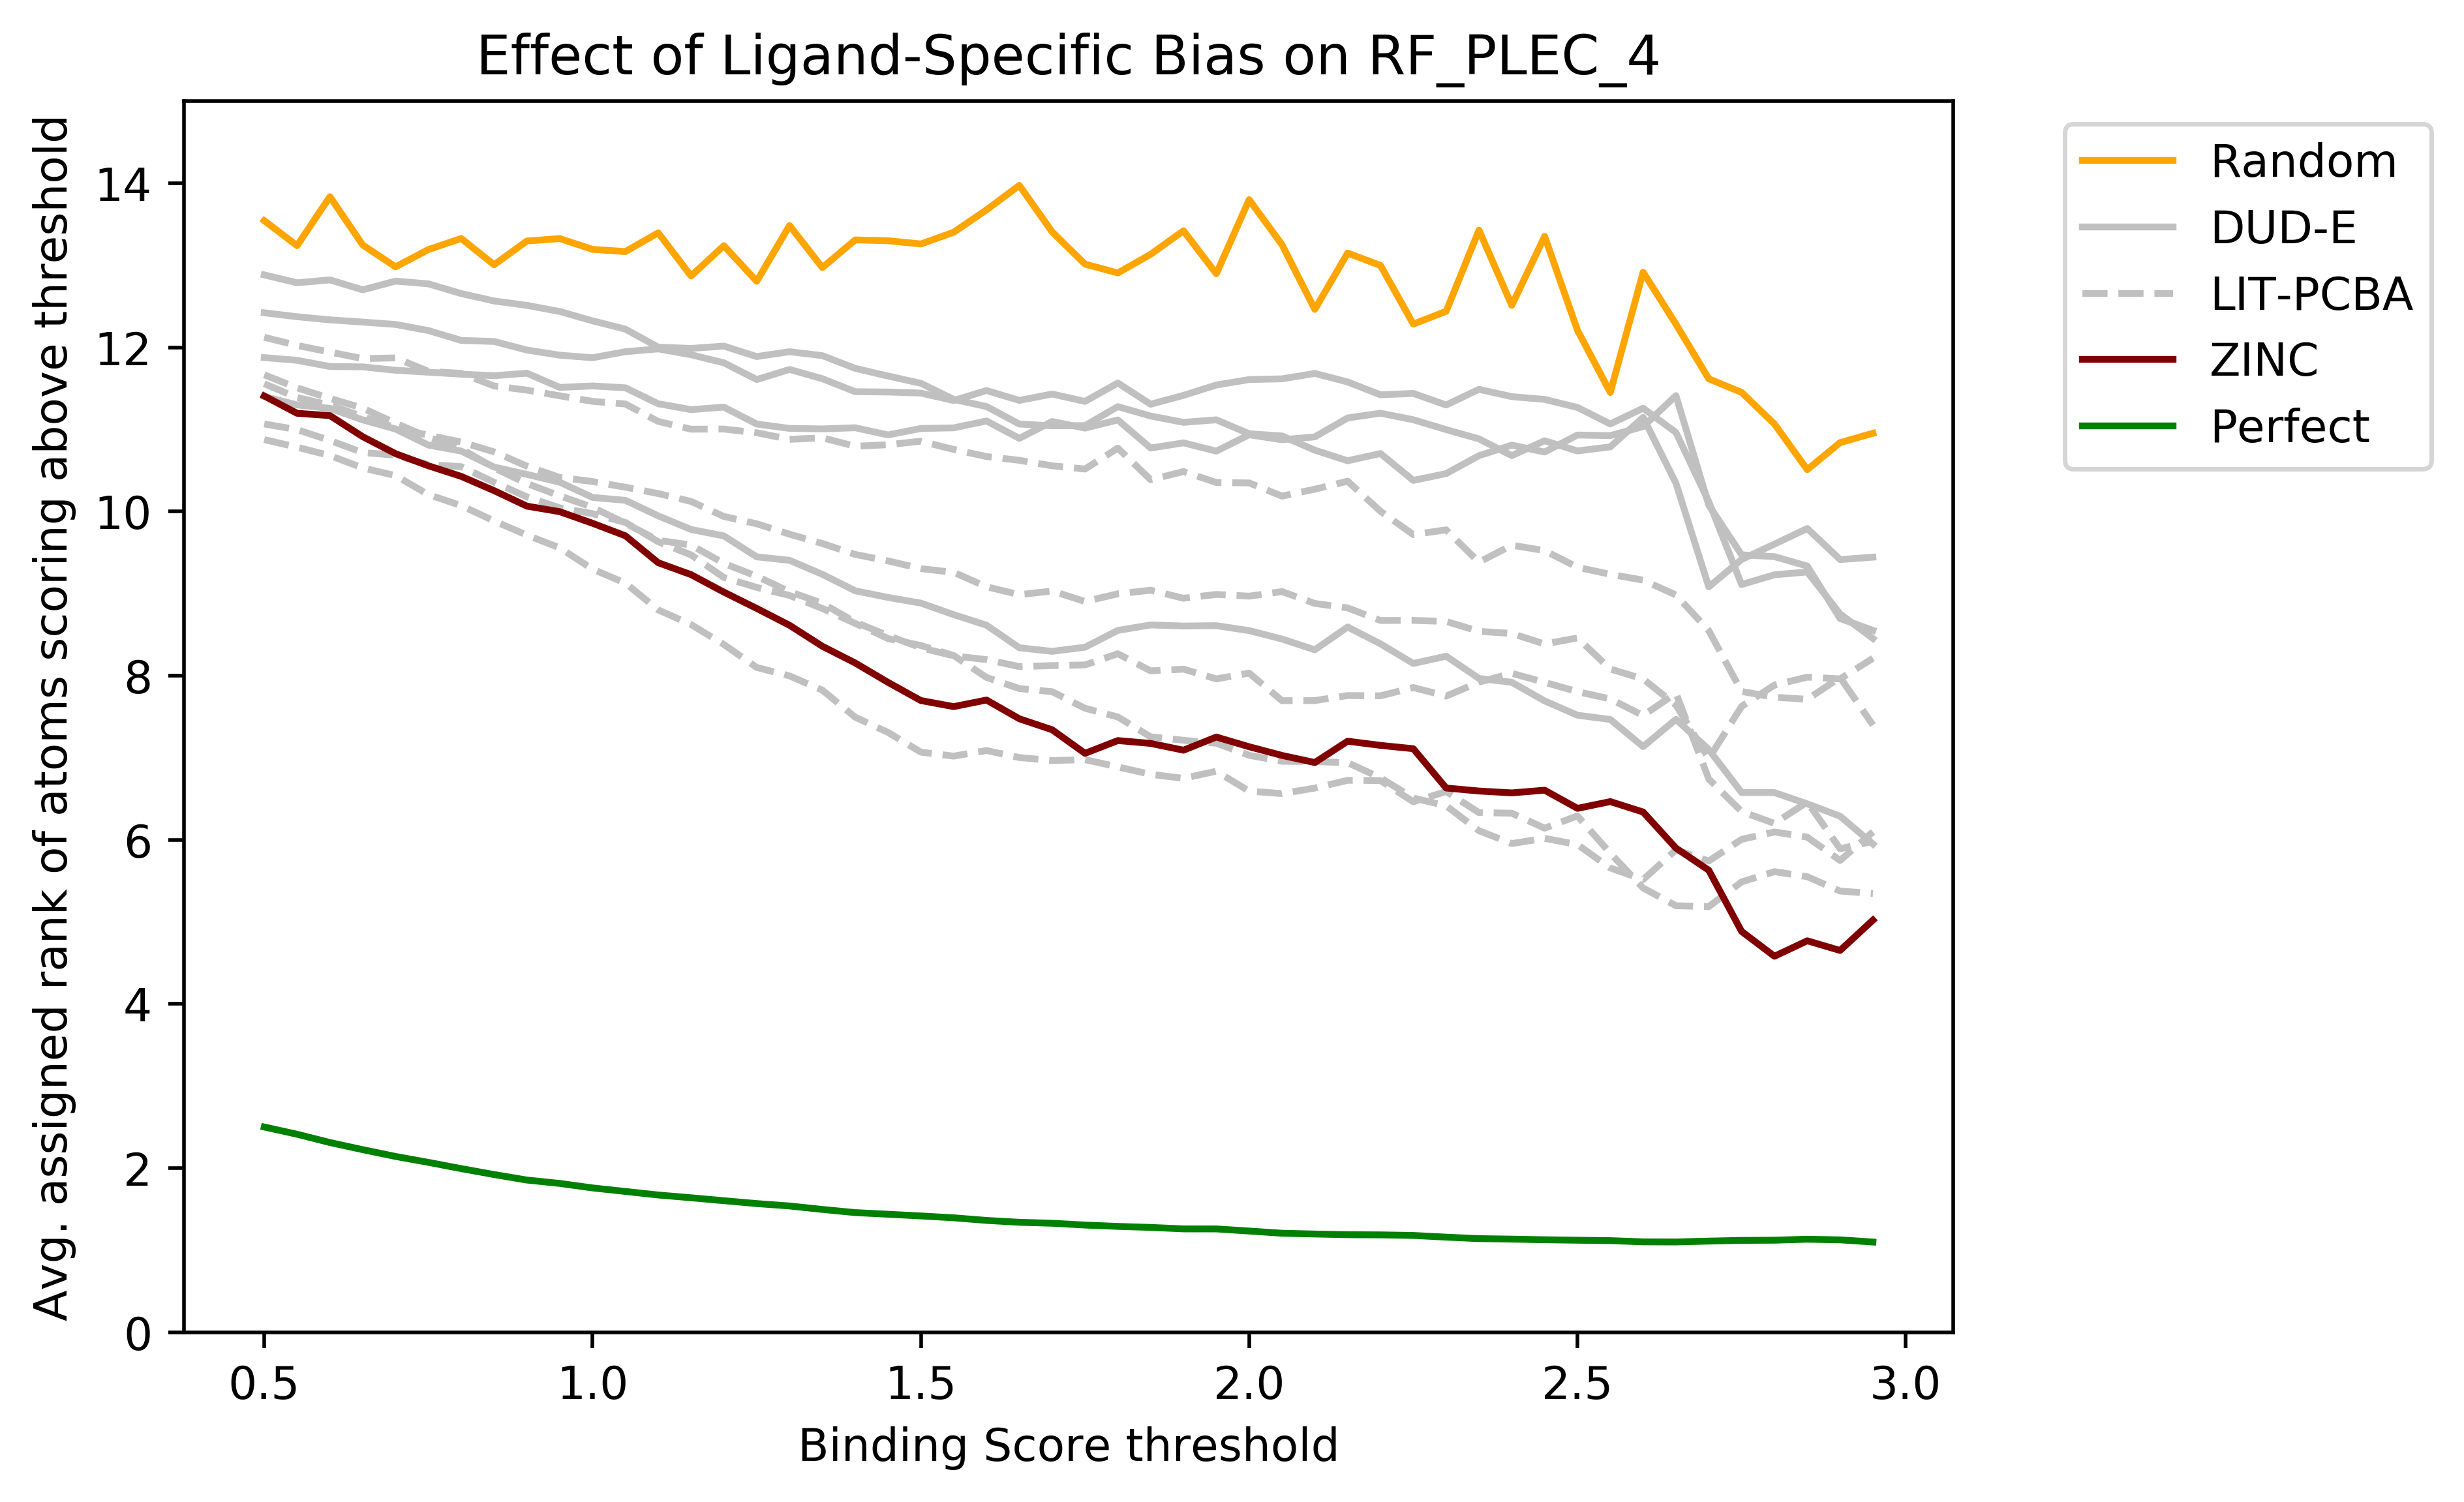

In [45]:
import matplotlib as mpl
c = np.arange(1, len(avg_rank_stat_pdbbind_rf.keys()) + 4)

norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Blues)
cmap.set_array([])


plt.figure(figsize = (7,5), dpi=500)

#plt.plot(np.arange(0.5, 3, 0.05), avg_rank_stat_pdbbind_egnn_200k, label = 'egnn_200k')

#plt.plot(np.arange(0.5, 3, 0.05), avg_rank_stat_pdbbind_rf, label = 'rf')


plt.plot(np.arange(0.5, 3, 0.05), avg_rank_stat_pdbbind_egnn_baseline, label = 'Random', color = 'orange')


#for i, pc in enumerate(avg_rank_stat_pdbbind_rf.keys()):
#    print(i, pc, i + 4)
#    plt.plot(np.arange(0.5, 3, 0.05), avg_rank_stat_pdbbind_rf[pc], label = f'rf_plec_{pc}', color=cmap.to_rgba(i + 4))

first_dude = True
first_lit = True

for i, target in enumerate(sorted(avg_rank_stat_pdbbind_biased_rf.keys())):
    print(i, target, i + 4)
    #plt.plot(np.arange(0.5, 3, 0.05), avg_rank_stat_pdbbind_egnn_biased[target], label = f'{target}', color=cmap.to_rgba(i + 4))

    
    if 'DUDE' in target:
        if first_dude:
            plt.plot(np.arange(0.5, 3, 0.05), avg_rank_stat_pdbbind_biased_rf[target], label = f'DUD-E', color="silver")
            first_dude = False
        else:
            plt.plot(np.arange(0.5, 3, 0.05), avg_rank_stat_pdbbind_biased_rf[target], color="silver")

        
    if 'LIT' in target:
        if first_lit:
            plt.plot(np.arange(0.5, 3, 0.05), avg_rank_stat_pdbbind_biased_rf[target], label = f'LIT-PCBA', color="silver", linestyle = 'dashed')
            first_lit = False
        else:
            plt.plot(np.arange(0.5, 3, 0.05), avg_rank_stat_pdbbind_biased_rf[target], color="silver", linestyle = 'dashed')



for i, target in enumerate(sorted(avg_rank_stat_pdbbind_egnn_biased.keys())):
    print(i, target, i + 4)
    #plt.plot(np.arange(0.5, 3, 0.05), avg_rank_stat_pdbbind_egnn_biased[target], label = f'{target}', color=cmap.to_rgba(i + 4))
    
    
    
#plt.plot(np.arange(0.5, 3, 0.05), avg_rank_stat_pdbbind_egnn, label = 'ZINC', color = 'red')
plt.plot(np.arange(0.5, 3, 0.05), avg_rank_stat_pdbbind_rf['4'], label = f'ZINC', color='maroon')

plt.plot(np.arange(0.5, 3, 0.05), avg_rank_stat_pdbbind_egnn_best, label = 'Perfect', color = 'green')    
    
plt.ylim((0,15))
plt.xlabel('Binding Score threshold')
plt.ylabel('Avg. assigned rank of atoms scoring above threshold')
#plt.legend()
plt.legend(bbox_to_anchor=(1.05, 1))
plt.title('Effect of Ligand-Specific Bias on RF_PLEC_4')
#plt.savefig('/data/hookbill/hadfield/syntheticVS/figures_for_paper/hydrophobic_attribution_2.png', bbox_inches='tight')
plt.show()